In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import Subset
from torchsummary import summary
import numpy as np
from tqdm import tqdm

In [14]:
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
train_full = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_full = datasets.FashionMNIST('data', train=False, download=True, transform=transform)
n = 50
rng = np.random.default_rng(42)
train_idx = rng.choice(len(train_full), len(train_full)//n, replace=False)
test_idx = rng.choice(len(test_full), len(test_full)//n, replace=False)
train_loader = torch.utils.data.DataLoader(Subset(train_full, train_idx), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(Subset(test_full, test_idx), batch_size=BATCH_SIZE, shuffle=False)

In [16]:
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
EPOCHS = 20
accs, losses = [], []
with tqdm(total=EPOCHS, desc='Training Progress') as pbar:
    for epoch in range(EPOCHS):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x).logits
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
        
        model.eval()
        correct, total_loss = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                total_loss += F.cross_entropy(out, y, reduction='sum').item()
                correct += (out.argmax(dim=1) == y).sum().item()
        acc = correct / len(test_loader.dataset)
        avg_loss = total_loss / len(test_loader.dataset)
        accs.append(acc)
        losses.append(avg_loss)
        pbar.set_postfix({'Epoch': epoch + 1, 'Accuracy': acc, 'Loss': avg_loss})
        pbar.update(1)

Training Progress: 100%|██████████| 20/20 [05:33<00:00, 16.70s/it, Epoch=20, Accuracy=0.885, Loss=0.549]


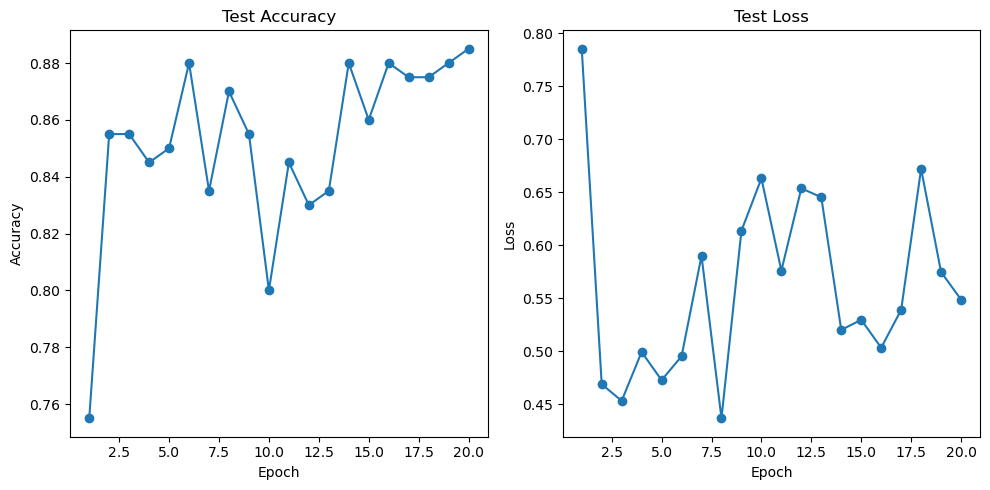

In [18]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), accs, marker='o')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), losses, marker='o')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()